In [1]:
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
import rpy2
from pprint import pprint
import re
import numpy as np
import pickle
from collections import OrderedDict
from itertools import repeat, count, product
from skbio.alignment import StripedSmithWaterman, local_pairwise_align_ssw
%run lib.ipynb

In [2]:
path = "../../david_eccles_bc_ideas/"
SRATE = 5000

In [3]:
robjects.r['load']("../../david_eccles_bc_ideas/mtDNA_mappable_called_with_rawSignal.Rdata")

<StrVector - Python:0x7f9e07aeb548 / R:0x3910558>
['nanopore.bundled']

In [4]:
data = numpy2ri.ri2py(robjects.r['nanopore.bundled'])

In [5]:
files = !ls ../../david_eccles_bc_ideas/processed/ | grep fast5

In [6]:
def get_file_and_channel(filename):
    result = re.search(r'_ch(\d+)_file(\d+)_', file)
    file_id = int(result.group(2))
    channel_id = int(result.group(1))
    return file_id, channel_id

### Get data from RData

0 = reference
1 = called
3 = channel
8 = metrichor results (events)
9 = "mux"
10 = signal range 
11 = signal

In [7]:
ref = data[0][0]
channel_ids = [int(x) for x in data[3]]
file_ids = [int(x) for x in data[5]]
types = list(data[2].names) #template/2D/...

In [8]:
## channel coords from rdata
coords = []
all_raw = {}
channel_max = dict(zip(channel_ids, repeat(0)))
for i in range(0, len(data[10]), 2):
    se = (round(data[10][i]), round(data[10][i+1]))
    coords.append(se)
    channel_max[channel_ids[int(i/2)]] = max(channel_max[channel_ids[int(i/2)]], se[1])
    
print (channel_max)

for chid, chmax in channel_max.items():
    all_raw[chid] = np.empty(chmax)
    all_raw[chid].fill(-1)

{195: 4638530, 132: 69987497, 133: 12456817, 135: 62976700, 201: 4599826, 227: 18246574, 203: 6371298, 204: 13066295, 141: 29953471, 142: 53380406, 206: 55940501, 209: 25813234, 211: 62405297, 212: 35840257, 149: 57367518, 215: 59538461, 223: 67207073, 156: 63222798, 157: 7725489, 213: 35016383}


pack all the available raw signal for the given channel in one array. 

In [9]:
for i, start_end in enumerate(coords):
    start, end = start_end
    print(i, start)
    for k, sig in enumerate(data[11][i]):
        all_raw[channel_ids[i]][start + k] = sig

0 14263383
1 14263383
2 53054262
3 55559668
4 55763736
5 55559668
6 20841985
7 21744018
8 20841663
9 58611017
10 29733238
11 30178940
12 38452561
13 68761506
14 69336966
15 39203872
16 4338899
17 10117943
18 10111547
19 1610262
20 1610262
21 437216
22 1290055
23 25820667
24 28685564
25 29586312
26 28684851
27 36094944
28 36495057
29 36094944
30 38381291
31 60958967
32 60827554
33 62183810
34 13895041
35 14282593
36 14883605
37 16839366
38 17196412
39 11116981
40 12018853
41 28113526
42 50760609
43 52030192
44 11786742
45 11971416
46 4415895
47 14826058
48 15605747
49 17611679
50 15605747
51 50100827
52 50279488
53 50100827
54 54684243
55 56708683
56 62911375
57 4682908
58 9660018
59 10549882
60 9660018
61 1262851
62 2095322
63 3367671
64 5777375
65 3310668
66 4523542
67 3724151
68 2837075
69 12054328
70 2865115
71 4214741
72 5115935
73 12445897
74 13721867
75 16388228
76 15418914
77 6253118
78 6213608
79 8839630
80 9700201
81 8839630
82 27325701
83 28050421
84 27325701
85 30627084
86 5

### Get events and sequence via poretools 

only look at the "template" seq for the beginning

####Events-Table
file	strand	mean	start	stdv	length	model_state	model_level	move	p_model_state	mp_model_state	p_mp_model_state	p_A	p_C	p_G	p_T	raw_index

In [10]:
file_data = []
for file in files: 
    f_obj = {}
    file_id, ch_id = get_file_and_channel(file)
    f_obj["channel"] = ch_id
    f_obj["file_id"] = file_id
    
    called_seq = !poretools fasta {path+"processed/" + file} | grep template -A1 | grep -v ">"
    f_obj["called_seq"] = called_seq[0]
    
    events = !poretools events {path+"processed/" + file} | grep template
    events = [line.split("\t") for line in events]
    
    file_events = []
    for ev in events: 
        r_ev = dict()
        r_ev["start"] = round(float(ev[3]) * SRATE)
        r_ev["end"] = round(r_ev["start"] + float(ev[5]) * SRATE)
        r_ev["mp_kmer"] = ev[10] #maximum posterior
        r_ev["kmer"] = ev[6] #model state
        r_ev["move"] = int(ev[8])
        file_events.append(r_ev)

    ## check if raw data is available
    file_id, ch_id = get_file_and_channel(file)
    if (all_raw[ch_id][file_events[0]["start"]] < 0 or
        all_raw[ch_id][file_events[-1]["end"]-1] < 0): 
        print("file ch{0}-file{1} skipped. No raw data available.".format(ch_id, file_id))
        continue
        
    f_obj["channel"] = ch_id
    f_obj["file_id"] = file_id
    f_obj["events"] = file_events
    file_data.append(f_obj)
    
    

file ch135-file25 skipped. No raw data available.
file ch141-file19 skipped. No raw data available.
file ch149-file12 skipped. No raw data available.
file ch149-file14 skipped. No raw data available.
file ch203-file1 skipped. No raw data available.
file ch206-file10 skipped. No raw data available.
file ch206-file34 skipped. No raw data available.
file ch211-file29 skipped. No raw data available.


In [11]:
from pylab import * 
import seaborn as sns
%matplotlib inline
sns.set_style("ticks", {"axes.grid" : True, "grid.color" : ".95"})

#Distribution of all events 

In [12]:
props = {
    "mean" : [], 
    "length" : [],
    "stdev" : []
}
for file in file_data:
    ch = file["channel"]
    for ev in file["events"]:
        l, r = ev["start"], ev["end"]
        props["mean"].append(np.mean(all_raw[ch][l:r]))        
        props["stdev"].append(np.std(all_raw[ch][l:r]))
        props["length"].append(r-l)

/home/sturm/bin/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


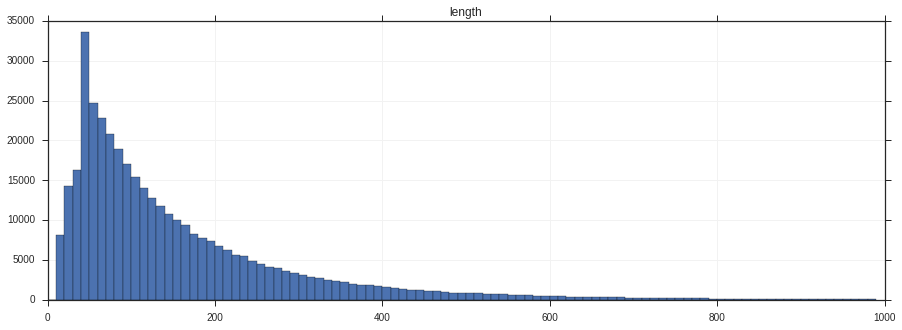

In [13]:
fig, ax = subplots(figsize=(15,5))
ax.hist(props["length"], bins=range(0, 1000, 10))
ax.set_title("length")
fig.show()

/home/sturm/bin/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


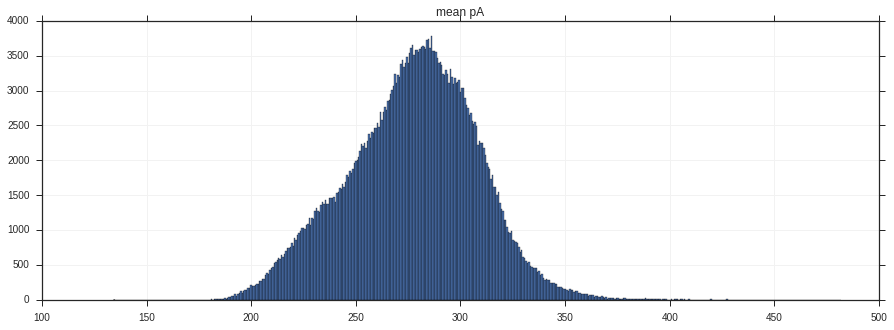

In [14]:
fig, ax = subplots(figsize=(15,5))
ax.hist(props["mean"], bins=500)
ax.set_title("mean pA")
fig.show()

/home/sturm/bin/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


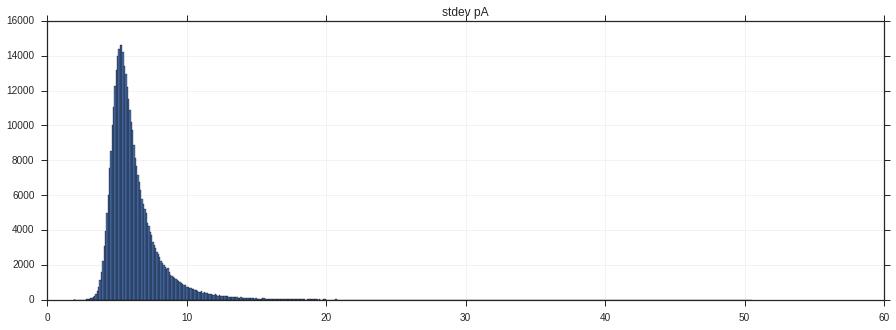

In [15]:
fig, ax = subplots(figsize=(15,5))
ax.hist(props["stdev"], bins=500)
ax.set_title("stdev pA")
fig.show()

#find all correctly mapped 5-mers

In [16]:
align_ref = StripedSmithWaterman(ref, gap_open_penalty=3, gap_extend_penalty=3) #query

In [17]:
def find_seq_start(events, start):
    """find the kmer that corresponds to the first kmer of the aligned sequences"""
    moved = 0
    for i, ev in enumerate(events):
        if moved + ev["move"] >= start: 
            offset = moved - start
            return i, offset
        else:
            moved += ev["move"]

In [18]:
def gapmove(i_seq, ts, move):
    """moves by *move* steps, respecting gaps."""
    moved = 0
    if i_seq < 0:
        return move  
    for i, c in enumerate(ts[i_seq:]): 
        if moved == move:
            return i
        if c != "-": moved +=1
        
            

In [19]:
true_events = []

for file in file_data:
    print("processing ", file["channel"], file["file_id"])
    alignment = align_ref(file["called_seq"]) #target
    events = file["events"]
#     print(alignment.aligned_query_sequence[:100])
#     print(alignment.aligned_target_sequence[:100])
    pos_kmer, offset = find_seq_start(events, alignment.target_begin)
    i_seq = offset #in case the last kmer was shifted by 2, i = sequence index of the target sequence with gaps
    qs = alignment.aligned_query_sequence #the reference
    ts = alignment.aligned_target_sequence #the called seq
    for ev in events[pos_kmer:]:
        i_seq += gapmove(i_seq, ts, ev["move"])
        
        q_kmer = qs[i_seq:i_seq+5]
        t_kmer = ts[i_seq:i_seq+5]
        t_kmer_gapless = ts[i_seq:].replace("-","")[:5]
            
        if len(t_kmer_gapless) < 5:
            """end of sequence"""
            break
            
        try:
            assert ev["kmer"] == t_kmer_gapless, "kmer from event file does not match aligned target sequence. "
        except AssertionError: 
            print(i_seq)
            print(len(ts))
            print(" " * i_seq + t_kmer)
            print(" " * i_seq + q_kmer)
            print(" " * i_seq + t_kmer_gapless)
            break
        
        if q_kmer == t_kmer:
            true_events.append(ev)        
    

processing  132 10
processing  132 17
processing  132 23
processing  132 25
processing  132 26
processing  132 35
processing  132 36
processing  132 38
processing  132 3
processing  132 44
processing  133 11
processing  133 2
processing  135 0
processing  135 17
processing  135 19
processing  135 23
processing  135 32
processing  135 33
processing  141 12
processing  141 13
processing  141 15
processing  141 8
processing  142 18
processing  142 3
processing  149 3
processing  156 10
processing  156 11
processing  156 15
processing  156 23
processing  156 3
processing  156 6
processing  157 0
processing  157 1
processing  195 3
processing  201 1
processing  203 2
processing  204 4
processing  204 5
processing  204 8
processing  206 12
processing  206 20
processing  206 21
processing  206 4
processing  206 7
processing  206 9
processing  209 14
processing  211 12
processing  211 17
processing  211 20
processing  211 26
processing  211 28
processing  211 35
processing  211 3
processing  2

In [20]:
len(true_events)

2321

well, that's not a lot!

### make dict with all kmers 

In [25]:
from itertools import product
all_5mers = [''.join(i) for i in product("ACGT",repeat=5)]
ev_map = OrderedDict((k,[]) for k in all_5mers)

In [26]:
for ev in true_events: 
    ev_map[ev["kmer"]].append(ev)

#Analysis

### compare with distributions in sequence

* kmer-frequence
* length (how many kmers were mapped correctly, at all) 

In [27]:
from collections import OrderedDict
import scipy as sp

In [28]:
kmer_freq = OrderedDict((k, 0) for k in all_5mers)
for i in range(0, len(ref)-4):
    kmer_freq[ref[i:i+5]] += 1

In [29]:
true_kmer_freq = OrderedDict((k, len(v)) for k, v in ev_map.items())

In [30]:
sp.stats.pearsonr(list(true_kmer_freq.values()), list(kmer_freq.values()))

(0.69704868551860544, 8.1041535619808629e-150)

/home/sturm/bin/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


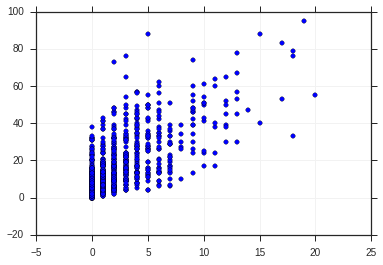

In [31]:
fig, ax = subplots()
ax.scatter(list(true_kmer_freq.values()), list(kmer_freq.values()))
fig.show()

In [32]:
tr = sum(list(true_kmer_freq.values()))
tot = sum([len(f["called_seq"]) for f in file_data])
print("true_kmers ", tr)
print("total_kmers in reads", tot)
print("ratio", tr/tot)

true_kmers  2321
total_kmers in reads 407165
ratio 0.00570039173308


### => Result

* the number of reads that are *totally* correct is really low...
    * (this is partly due to the fact, that the alignments are cropped)
* there is a pretty strong correlation (pearson r = .7) between the frequency of kmers in the reference and the frequency of correctly predicted kmers
    * this indicates that there is no direct evidence for specific base-pairs to be perdicted at low accuracy (there could be single ones, however)
   